# Predicting Gene Sequence Regenerative Contributions 

By: Jaeyoon Jung, Jeremy Milford, Shree Patel, Cynthia Perez

This notebook develops a model from gene sequences of the axolotl and zebrafish, model regenerative species. This notebook uses feature engineered data to run gridsearch, PCA, and maps the gene data to amino acid sequences to explore biological implications. 

### Necessary Imports

In [3]:
# necessary imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.optimizers import Adam
#from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
#import shap
#from scipy.stats import ttest_ind
from sklearn.model_selection import KFold


In [4]:
features_df = pd.read_csv("gene_features_3mer.csv")
features_df.head()

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_GGG,kmer_3_GGC,kmer_3_GCG,kmer_3_CGG,kmer_3_GCT,kmer_3_CTG,...,kmer_3_GTA,kmer_3_TAG,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA,organism,chromosome,regen
0,HOXA13,2800,0.522857,0.912568,0.024303,0.022873,0.021801,0.018585,0.016083,0.019657,...,0.012509,0.006791,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,2q,1
1,TWIST3,2729,0.485892,1.058069,0.012101,0.013568,0.009534,0.009534,0.014668,0.023836,...,0.008801,0.007701,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,3q,1
2,HOXD10,4207,0.467792,1.137703,0.013793,0.014744,0.011415,0.009512,0.013793,0.017122,...,0.014982,0.009275,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,9,1
3,HOXD11,7743,0.439623,1.274677,0.016148,0.012660,0.011110,0.012014,0.013435,0.017052,...,0.013177,0.008655,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,9,1
4,TGFBR1,360240,0.465784,1.146918,0.017819,0.013591,0.006054,0.007251,0.013766,0.019581,...,0.012125,0.011559,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,5q,1


### Test, Train Split

In [13]:
# Drop gene_name and separate features and target 
X = features_df.drop(columns=['gene_name'])
y = (features_df['regen']).astype(int)  

# Choose only numeric features for modeling
X_col = X.columns
X_numeric_features = ["sequence_length", "gc_content", "at_gc_ratio", 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       'kmer_3_ATA', 'kmer_3_GTA', 'kmer_3_TAG', 'kmer_3_CAN', 'kmer_3_ANN',
       'kmer_3_NNN', 'kmer_3_NNT', 'kmer_3_NTA']

X_num = X[X_numeric_features]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)


This train, test split has considered only the numerical features of the data (i.e. no information on organism or chromosome location of the gene)

### CNN on Feature DataFrame

In [6]:
model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train, Y_train,
    epochs=50,                 # Maximum number of epochs
    batch_size=16,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping])  # Add the EarlyStopping callback here

/opt/miniconda3/envs/chem274A_lab2/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.5833 - loss: 0.6944 - val_accuracy: 0.4118 - val_loss: 0.7113
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5354 - loss: 0.6788 - val_accuracy: 0.4118 - val_loss: 0.7080
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5729 - loss: 0.6733 - val_accuracy: 0.4118 - val_loss: 0.7060
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5167 - loss: 0.6645 - val_accuracy: 0.4118 - val_loss: 0.7054
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6521 - loss: 0.6609 - val_accuracy: 0.4706 - val_loss: 0.7074
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5771 - loss: 0.6555 - val_accuracy: 0.4706 - val_loss: 0.7100
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6438 - loss: 0.6348 - val_accuracy: 0.4706 - val_loss: 0.7188


### K-Fold CV

In [ ]:
# Function to initialize model each fold
def create_model(input_shape):
    model = Sequential([
        Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Define k-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracy = []
kf_loss = []

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Initialize model for every fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Training fold {fold + 1}/{kf.get_n_splits()}...")
    x_train_fold, x_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    model = create_model(x_train_fold.shape[1:])    #Initialize model for fold
    history = model.fit(
        X_train, Y_train,
        epochs=50,                 # Maximum number of epochs
        batch_size=16,
        validation_data=(X_test, Y_test),
        callbacks=[early_stopping]) 
    # Evaluate model 
    val_loss, val_acc = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    # Add results
    kf_loss.append(val_loss)
    kf_accuracy.append(val_acc)
    print(f"Fold {fold + 1} - Validation Accuracy: {val_acc:.4f} - Validation Loss: {val_loss:.4f}")

Training fold 1/5...


/opt/miniconda3/envs/chem274A_lab2/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.4563 - loss: 0.6993 - val_accuracy: 0.4118 - val_loss: 0.6948
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5708 - loss: 0.6882 - val_accuracy: 0.4118 - val_loss: 0.7043
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4729 - loss: 0.6839 - val_accuracy: 0.4118 - val_loss: 0.7098
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5958 - loss: 0.6685 - val_accuracy: 0.4118 - val_loss: 0.7184
Fold 1 - Validation Accuracy: 0.5385 - Validation Loss: 0.6908
Training fold 2/5...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.4292 - loss: 0.6930 - val_accuracy: 0.5882 - val_loss: 0.6943
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5479 - loss: 0.6885 - val_accuracy: 0.4118 - val_loss: 0.7081
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6062 - loss: 0.6643 - val_accuracy: 0.4118 - val_loss: 0.7278
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

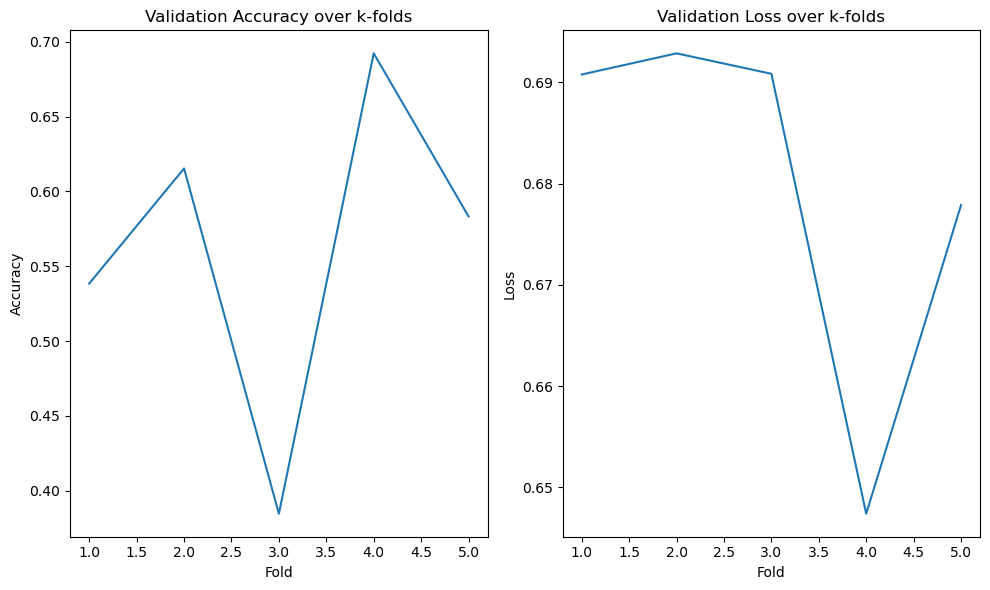

In [17]:
plt.figure(figsize=(10,6))
# Plot accuracy vs folds
plt.subplot(1,2,1)
plt.plot(range(1, len(kf_accuracy)+1), kf_accuracy, label="Validation Accuracy")
plt.title('Validation Accuracy over k-folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
# Plot loss vs folds
plt.subplot(1,2,2)
plt.plot(range(1, len(kf_loss) +1), kf_loss, label='Validation Loss')
plt.title('Validation Loss over k-folds')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

The parameters for this CNN were chosen based on our previous trials in model development. We are seeing early stoppage. Let us consider altering the parameters we are using through GridSearch

### Gridsearch to Improve CNN

In [7]:
# Define a Model Builder
def build_model(optimizer='adam', dropout_rate=0.3):
    model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(dropout_rate),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Metric to monitor (validation loss in this case)
        patience=3,             # Number of epochs with no improvement after which training stops
        restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
    )

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# ~20 min run time

model = KerasClassifier(build_fn=build_model, verbose=0, dropout_rate=0.2)

param_grid = {
    'optimizer': ['adam', 'rmsprop'],  # Optimizer choices
    'dropout_rate': [0.2, 0.3, 0.5],  # Dropout rate options
    'batch_size': [16, 32, 64],  # Batch size options
    'epochs': [10, 20, 50]  # Number of epochs to train for
}

# Initialize GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)

# Fit the GridSearchCV to the training data
grid_result = grid.fit(X_train, Y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py

/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py

### Un-altered Data with Gridsearch Evaluation

Best: 0.702020 using {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/50


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.6499 - loss: 0.6804 - val_accuracy: 0.4615 - val_loss: 0.6837
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5414 - loss: 0.6775 - val_accuracy: 0.4615 - val_loss: 0.6840
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6092 - loss: 0.6562 - val_accuracy: 0.4615 - val_loss: 0.6861
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5821 - loss: 0.6553 - val_accuracy: 0.4615 - val_loss: 0.6688
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5420 - loss: 0.6570 - val_accuracy: 0.4615 - val_loss: 0.6849
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5134 - loss: 0.6636 - val_accuracy: 0.5385 - val_loss: 0.6621
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6306 - loss: 0.6447 - val_accuracy: 0.6923 - val_loss: 0.6465
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6082 - loss: 0.6224 - val_accuracy: 0.5385 - val_loss: 0.6562
Epoch 9/50

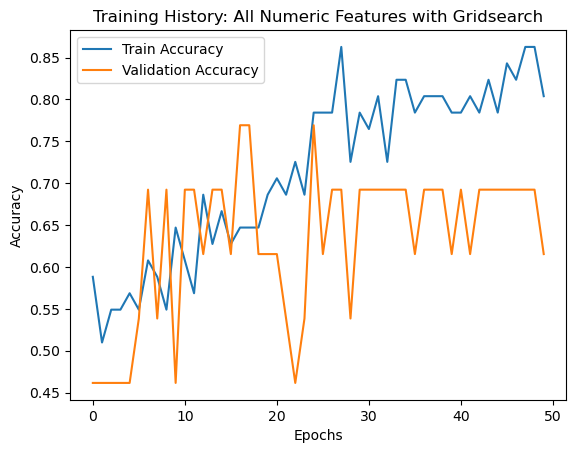

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Test Accuracy: 0.5294117647058824


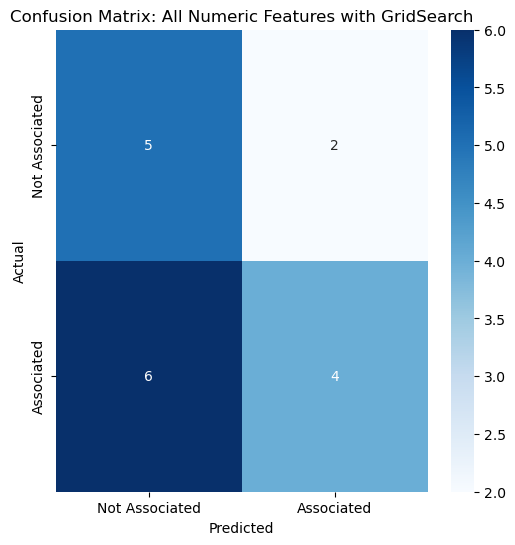

                precision    recall  f1-score   support

Not Associated       0.45      0.71      0.56         7
    Associated       0.67      0.40      0.50        10

      accuracy                           0.53        17
     macro avg       0.56      0.56      0.53        17
  weighted avg       0.58      0.53      0.52        17



In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Use the best model to make predictions
best_model = grid_result.best_params_
# Create the model using the best parameters
model = build_model(dropout_rate=best_model['dropout_rate'],
                     optimizer=best_model['optimizer'])

# Fit the model and get the history
history = model.fit(X_train, Y_train, epochs=best_model['epochs'], batch_size=best_model['batch_size'], validation_split=0.2)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: All Numeric Features with Gridsearch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: All Numeric Features with GridSearch")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))

Let us also try PCA and see if the results are improved by using PCA. We shall run the model withour gridsearch first, then we will consider running gridsearch on a smaller set of parameters based on the best ones chosen by the non-PCA run 

### PCA

In [11]:
# define my PCA function

def apply_pca(X_train, X_test, n_components=5):
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("Explained variance by PCA components:", pca.explained_variance_ratio_)
    return X_train, X_test, pca.explained_variance_ratio_, pca

Explained variance by PCA components: [0.42952861 0.12602611 0.08797919 0.08023777]


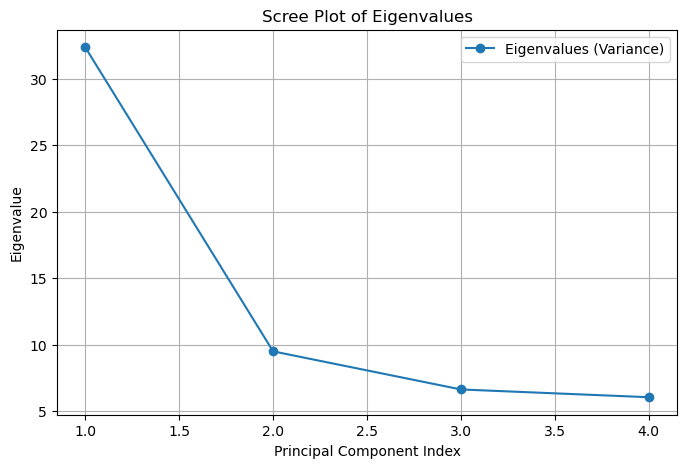

In [12]:
X_train_PCA, X_test_PCA, var_ratio, pca_obj = apply_pca(X_train, X_test, n_components=4)

#Plotting the cumulative variance
eigenvalues = pca_obj.explained_variance_

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues (Variance)')
plt.title("Scree Plot of Eigenvalues")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.legend()
plt.show()

We have tried running the model with PCA from 3-6 components, we found 4 works best. We will use 4 features for the modeling work onwards. Let's use the best features we discovered from the last model

In [13]:
model = Sequential([
    Reshape((X_train_PCA.shape[1], 1), input_shape=(X_train_PCA.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train_PCA, Y_train,
    epochs=50,                 # Maximum number of epochs
    batch_size=16,
    validation_data=(X_test_PCA, Y_test),
    callbacks=[early_stopping])  # Add the EarlyStopping callback here

Epoch 1/50


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.4958 - loss: 0.6837 - val_accuracy: 0.7059 - val_loss: 0.6767
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6271 - loss: 0.6641 - val_accuracy: 0.7647 - val_loss: 0.6662
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6417 - loss: 0.6653 - val_accuracy: 0.7647 - val_loss: 0.6567
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6438 - loss: 0.6616 - val_accuracy: 0.7647 - val_loss: 0.6483
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6250 - loss: 0.6642 - val_accuracy: 0.7647 - val_loss: 0.6420
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7271 - loss: 0.6343 - val_accuracy: 0.7647 - val_loss: 0.6366
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6479 - loss: 0.6299 - val_accuracy: 0.7647 - val_loss: 0.6309
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7208 - loss: 0.6299 - val_accuracy: 0.7647 - val_loss: 0.6294
Epoch 9/50

Note: we encounter early stoppage, but our results seem to be better than the last model

### PCA with CNN Evaluation

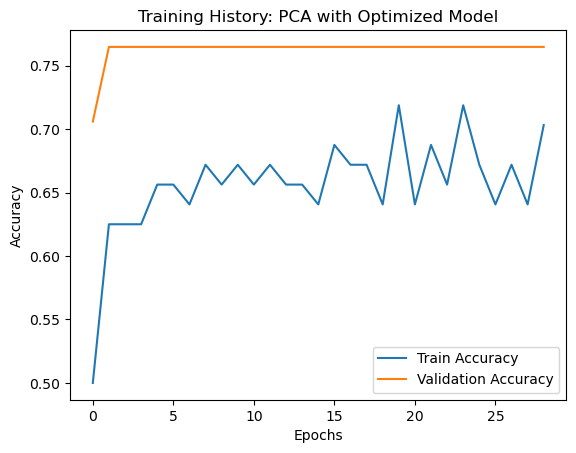

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test Accuracy: 0.7647058823529411


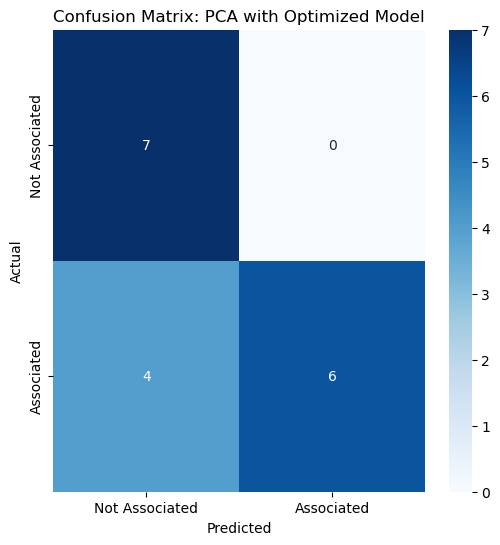

                precision    recall  f1-score   support

Not Associated       0.64      1.00      0.78         7
    Associated       1.00      0.60      0.75        10

      accuracy                           0.76        17
     macro avg       0.82      0.80      0.76        17
  weighted avg       0.85      0.76      0.76        17



In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: PCA with Optimized Model")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = model.predict(X_test_PCA)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: PCA with Optimized Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))

Okay, we are receiving decent results. Let us try gridsearch as well to see if the accuracy will improve

### PCA with GridSearch CNN

In [16]:
def build_model(optimizer='adam', dropout_rate=0.3):
    model = Sequential([
    Reshape((X_train_PCA.shape[1], 1), input_shape=(X_train_PCA.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(dropout_rate),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Metric to monitor (validation loss in this case)
        patience=3,             # Number of epochs with no improvement after which training stops
        restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
    )

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=build_model, verbose=0, dropout_rate=0.2)

param_grid = {
    'optimizer': ['adam', 'rmsprop'],  # Optimizer choices
    'dropout_rate': [0.2, 0.3, 0.5],  # Dropout rate options
    'batch_size': [16, 32, 64],  # Batch size options
    'epochs': [20, 30, 50]  # Number of epochs to train for
}

# Initialize GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)

# Fit the GridSearchCV to the training data
grid_result = grid.fit(X_train_PCA, Y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py

Best: 0.702020 using {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'adam'}
Epoch 1/20


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.5901 - loss: 0.6905 - val_accuracy: 0.6923 - val_loss: 0.6749
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6266 - loss: 0.6851 - val_accuracy: 0.6923 - val_loss: 0.6687
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6397 - loss: 0.6839 - val_accuracy: 0.6923 - val_loss: 0.6631
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6501 - loss: 0.6749 - val_accuracy: 0.6923 - val_loss: 0.6574
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6944 - loss: 0.6706 - val_accuracy: 0.6923 - val_loss: 0.6517
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6189 - loss: 0.6607 - val_accuracy: 0.6923 - val_loss: 0.6459
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6710 - loss: 0.6540 - val_accuracy: 0.6923 - val_loss: 0.6407
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6240 - loss: 0.6570 - val_accuracy: 0.6923 - val_loss: 0.6360
Epoch 9/20

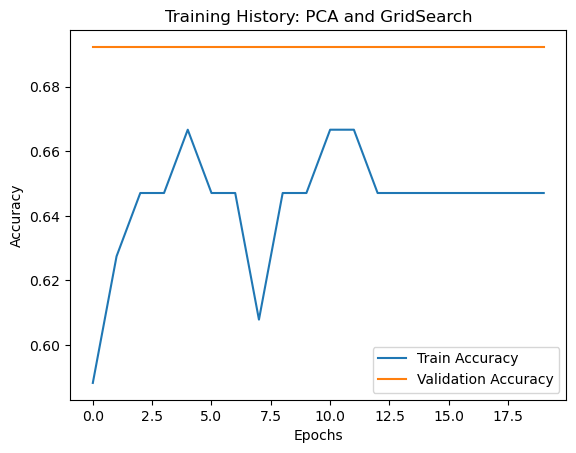

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Test Accuracy: 0.7058823529411765


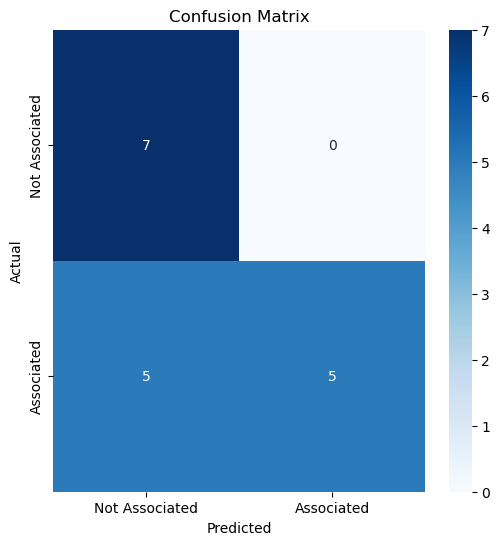

                precision    recall  f1-score   support

Not Associated       0.58      1.00      0.74         7
    Associated       1.00      0.50      0.67        10

      accuracy                           0.71        17
     macro avg       0.79      0.75      0.70        17
  weighted avg       0.83      0.71      0.70        17



In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Use the best model to make predictions
best_model = grid_result.best_params_
# Create the model using the best parameters
model = build_model(dropout_rate=best_model['dropout_rate'],
                     optimizer=best_model['optimizer'])

# Fit the model and get the history
history = model.fit(X_train_PCA, Y_train, epochs=20, batch_size=32, validation_split=0.2)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: PCA and GridSearch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = model.predict(X_test_PCA)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: PCA and GridSearch")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))

We've modeled our dataset with a wide variety of techniques. Let us see what this means contextualized with biology